<a href="https://colab.research.google.com/github/wjdemthf/Data_Analysis_Programming/blob/main/DAP_Project_Steam_Store_Game_Analysis(Final)_201714220_Deunsol_Jeong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Analysis Programming: Project**
## - Steam Store Game Analysis - 


- Background

> COVID-19의 발생에 따라 Indoor Activity 사업이 크게 성장하였다. 그와 더불어
현재 다양한 게임회사들이 P2E(Play to Earn) 모델을 성공적으로 정착시키기 위해
게임플랫폼 사업에 많은 투자를 진행하고 있다. Steam은 게임플랫폼 업계의 최대 업
체 중 하나로 다양한 게임개발 업체들과 제휴를 맺고 있다. 향후 시대적으로 주목받
을 게임 장르를 분류하고 소비자의 관점에서 어떠한 평가와 정보를 토대로 가성비
있게 게임을 선택할지를 데이터 분석을 통해 알아보고자 한다.





# **Data Set**: Data





- Data Description


> Dataset created from scratch based around games on the Steam Store. Using data gathered from the `Steam Store` and `SteamSpy APIs`, this dataset provides information about various aspects of games on the store, such as its genre and the estimated number of owners. 

> Gathered around `May 2019`, it contains most games on the store released prior to that date. Unreleased titles were removed as well as many non-games like software, though some may have slipped through. 

> This dataset combined data of `27,075` games.

> There are `18 Attributes`. `object(9)`, `int64(8)`, `float64(1)` 

> Source: [Kaggle Datasets: Steam Store Games (Clean dataset)](https://www.kaggle.com/nikdavis/steam-store-games)


In [1]:
#@title Load Data Set

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataPath = 'https://raw.githubusercontent.com/wjdemthf/Data_Analysis_Programming/main/steam.csv'
data = pd.read_csv(dataPath)
data.head(3)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99


# **Data Set**: Preprocessing

- *Rating* (int64)

> `rating` = *positive_ratings* / (*positive_ratings* + *negative_ratings*)

> `tatal_ratings` = *positive_ratings* + *negative_ratings*

---

- *Release Date* (object)

> transfer data type of `release_date` to `Timestamp`

---

- *Owner* (object)

> `owner_level`: categorial level of *owners*. similar to [log(*owner*)]

> `owners`: Average of *owners*

---

- ETC

> Delete: *english*, *developer*, *platforms*, *categories*, *achivements*




In [2]:
#@title Preprocessing_1 (Rating, Relese Date, Owners, etc)

#ignore 'chained_assignment' error
pd.set_option('mode.chained_assignment',  None)

df = data

# Rating
df['rating'] = df['positive_ratings'] / (df['positive_ratings'] + df['negative_ratings'])
df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']

# Transform datatype of release_date
df['release_datetime'] = pd.to_datetime(df.release_date)

# Average owner str2int
for i in df.index:
  df.owners[i] = int((int(df.owners[i].split('-')[0]) + int(df.owners[i].split('-')[1])) / 2)

# Define owner_level
owner_levels = dict(enumerate(np.sort(df['owners'].unique())))
owner_levels = {v:k for k, v in owner_levels.items()} 

df['owner_level'] = df['owners']
for i in df.index:
  df['owner_level'][i] = owner_levels.get(df.owners[i])

# Drop unnecessary attributes
df.drop(columns=['release_date', 'english', 'developer', 'platforms', 'categories', 'achievements', 'positive_ratings', 'negative_ratings'])
df = df[['appid', 'release_datetime', 'publisher', 'required_age', 'genres', 'rating', 'total_ratings', 'average_playtime', 'median_playtime', 'owners', 'owner_level', 'price']]
df = df.rename(columns={'release_datetime' : 'release_date'})

df.head()

,appid,release_date,publisher,required_age,genres,rating,total_ratings,average_playtime,median_playtime,owners,owner_level,price
0,10,2000-11-01,Valve,0,Action,0.973888,127873,17612,317,15000000,9,7.19
1,20,1999-04-01,Valve,0,Action,0.839787,3951,277,62,7500000,8,3.99
2,30,2003-05-01,Valve,0,Action,0.895648,3814,187,34,7500000,8,3.99
3,40,2001-06-01,Valve,0,Action,0.826623,1540,258,184,7500000,8,3.99
4,50,1999-11-01,Valve,0,Action,0.947996,5538,624,415,7500000,8,3.99


- Genres (object) (1/3)


> split *genres* with " ; ". Collect unique values of genre and make `genre_set`. Add attributes of `gemre_set` with one-hot encoding



In [3]:
#@title Preprecessing_2 (Genres)

# Multi attribute genres split
df.genres.str.split(';').tolist()

genre_item = (set(g.split(';')) for g in df.genres)  #https://rfriend.tistory.com/381 [R, Python 분석과 프로그래밍의 친구 (by R Friend)]
genre_set = sorted(set.union(*genre_item))

appid_series = df['appid']
indicator_mat = pd.DataFrame(np.zeros((len(df), len(genre_set))), columns=genre_set)
indicator_mat = pd.concat([indicator_mat, appid_series], axis=1)

for i, genre in enumerate(df.genres):
  indicator_mat.loc[i, genre.split(';')] = 1

indicator_mat
df = pd.merge(df, indicator_mat)

- Genres (object) (2/3)

> Show less valuable or non-game item of `genre_set`


In [4]:
#@title Preprecessing_3 (Genres)

# Find NOT-game & unnecessary genre
genre_sum = []
tmp = []

for g in genre_set:
  tmp.append(g)
  tmp.append(indicator_mat[g].sum())
  genre_sum.append(tmp)
  tmp = []

genre_sum = pd.DataFrame(data=genre_sum, columns=['genre', 'sum']).sort_values(by='sum', ascending=False)
genre_sum.tail(int(len(genre_sum) / 2))

,genre,sum
19,Sexual Content,245.0
25,Utilities,146.0
6,Design & Illustration,87.0
3,Animation & Modeling,79.0
9,Education,51.0
26,Video Production,38.0
21,Software Training,31.0
4,Audio Production,29.0
28,Web Publishing,28.0
11,Game Development,17.0


- Genres (object) (3/3)

> Drop non-game & unnecessory genre

In [5]:
#@title Preprecessing_4 (Genres)

# Drop non-game & unnecessary genre
genre_drop = []

for i in genre_sum.index:
  if (genre_sum['sum'][i] < 150.0):
    genre_drop.append(genre_sum['genre'][i])
    genre_set.remove(genre_sum['genre'][i])

for g in genre_drop:
  idx_num = df[df[g] == 1.0].index
  df = df.drop(idx_num)
  df.drop(columns=[g], inplace=True)

df.head()

,appid,release_date,publisher,required_age,genres,rating,total_ratings,average_playtime,median_playtime,owners,owner_level,price,Action,Adventure,Casual,Early Access,Free to Play,Gore,Indie,Massively Multiplayer,Nudity,RPG,Racing,Sexual Content,Simulation,Sports,Strategy,Violent
0,10,2000-11-01,Valve,0,Action,0.973888,127873,17612,317,15000000,9,7.19,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20,1999-04-01,Valve,0,Action,0.839787,3951,277,62,7500000,8,3.99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30,2003-05-01,Valve,0,Action,0.895648,3814,187,34,7500000,8,3.99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40,2001-06-01,Valve,0,Action,0.826623,1540,258,184,7500000,8,3.99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,50,1999-11-01,Valve,0,Action,0.947996,5538,624,415,7500000,8,3.99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Time-Series & Regrression**: Time-Series & Correlation

- Trend

> Show trend of the number of released games.

> Compensate the number of 2019 released games. Last released game data is `2019-05-01`.

---

> Trend is increasing except in 2019. COVID-19 can be the one of the reason.






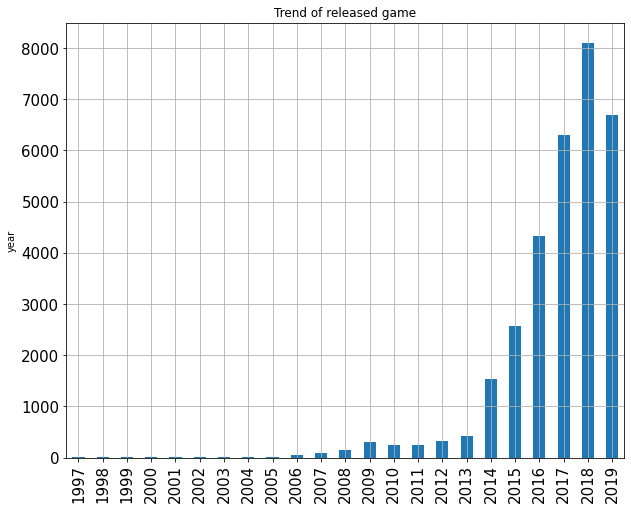

In [6]:
#@title Trend Analysis

# Time-Series Analysis: Trend
df['year'] = [d.year for d in df.release_date]
CountStatus = pd.value_counts(df['year'].values).sort_index()

# Compensate the number of 2019-released game
last_date = df.sort_values(by='release_date').tail(1)[['release_date']].reset_index()
days = last_date.release_date[0] - pd.to_datetime('2019-01-01')
CountStatus[2019] = CountStatus[2019] * 365 / days.days

CountStatus.plot.bar(title='Trend of released game')
CountStatus.plot.bar(ylabel='released game')
CountStatus.plot.bar(ylabel='year')
CountStatus.plot.bar(grid=True, figsize=(10,8), fontsize=15)

- Seasonality

> Show seaonality of the number of released games.

---

> Games are less released in `vacation` seasons than `non-vacation` seasons.

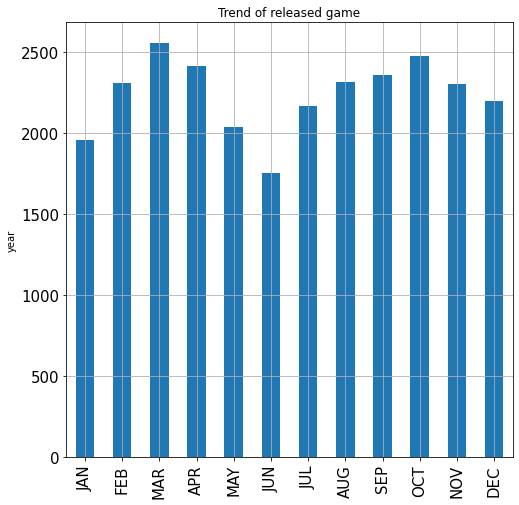

In [7]:
#@title Seasonality Analysis

# Time-Series Analysis: Seaonality
df['month'] = [d.month for d in df.release_date]
CountStatus = pd.value_counts(df['month'].values).sort_index()
CountStatus.index = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
CountStatus.plot.bar(title='Trend of released game')
CountStatus.plot.bar(ylabel='released game')
CountStatus.plot.bar(ylabel='year')
CountStatus.plot.bar(grid=True, figsize=(8, 8), fontsize=15)

- Correlation

> Show correlation between slected genres.

---

> Low correlation means the genres do not need demension reduction. 

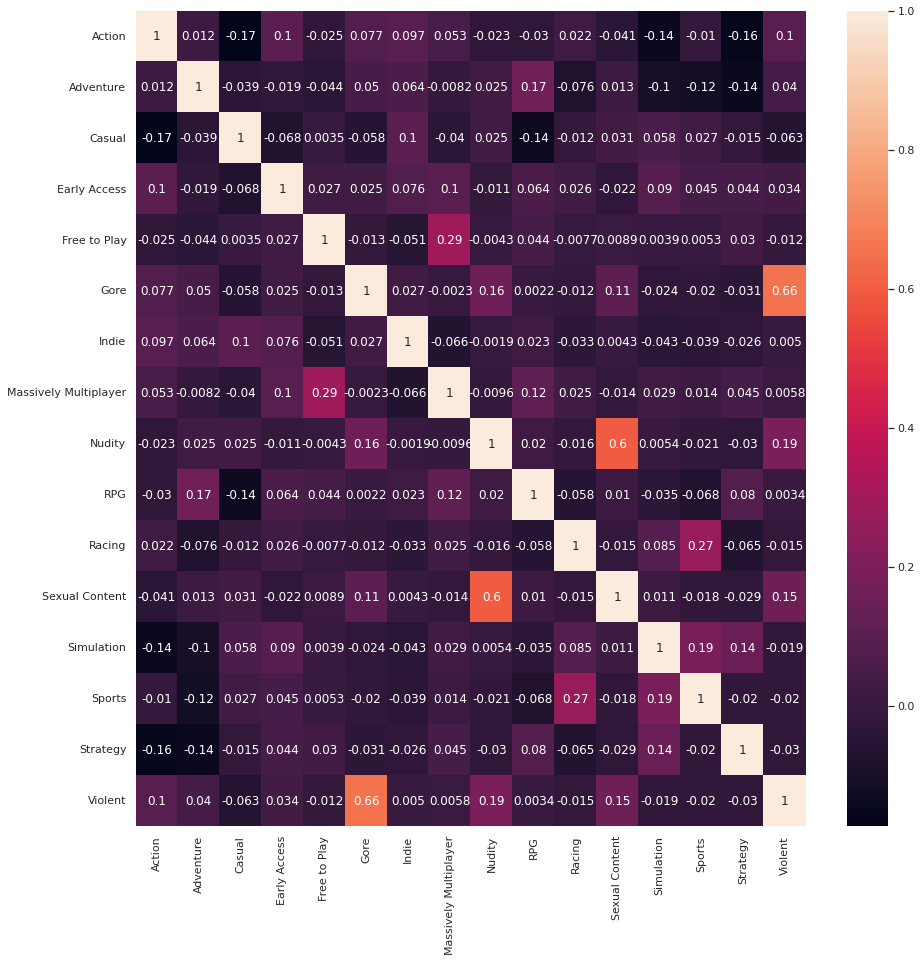

In [8]:
#@title Correlation of Genres Analysis

# Correlation between genre_set
corr=df[genre_set].corr()
sns.set(rc = {'figure.figsize':(15,15)})
sns.heatmap(corr, annot=True)

# **Time-Series & Regrression**: Linear Regression

- Linear Regression (1/2)

> Features: `average_playtime`, `price`, `owner_level`

> Target: `rating`

> test_set: 20% (`0.2`)

> random_state: `42`

In [9]:
#@title Linear Regression_1

from sklearn.model_selection import train_test_split

# Data Split: Regression(average_playtime, price, owner_level -> rating)
origin_features = ['average_playtime', 'price', 'owner_level']
X_train, X_test, y_train, y_test = train_test_split(df[origin_features], df['rating'], test_size=0.2, random_state=42)

- Linear Regression (2/2)

> Evaluation: MAE(Mean Absolute Error), MSE(Mean Squared Error), RMSE(Root Mean Squared Error), R2(R-Squard)

> Show coefficeint and constant between features and target.

---

> `average_playtime` less valuable at inffering `rating` than `price` or `owner_level`

In [10]:
#@title Linear Regression_2

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
predictions = lin_reg.predict(X_test)

# Evaluation
print("MAE: ", mean_absolute_error(y_test, predictions))
print("MSE: ", mean_squared_error(y_test, predictions))
print("RMSE: ", np.sqrt(mean_squared_error(y_test, predictions)))
print("R2: ", r2_score(y_test, predictions))

# Weights
print("\nCoefficient: ", lin_reg.coef_)
print("Constant: ", lin_reg.intercept_)

MAE:  0.1820250441124711
MSE:  0.0521602941026514
RMSE:  0.22838628264992492
R2:  0.00995685010614289

Coefficient:  [1.21765037e-06 2.19407297e-03 1.08492337e-02]
Constant:  0.6913875015699852


# **Clustering**: Handling Outlier & Scaling(Normalization)

- Handling Outlier (1/2)

> Show scatterplot between `average_playtime` and `price`

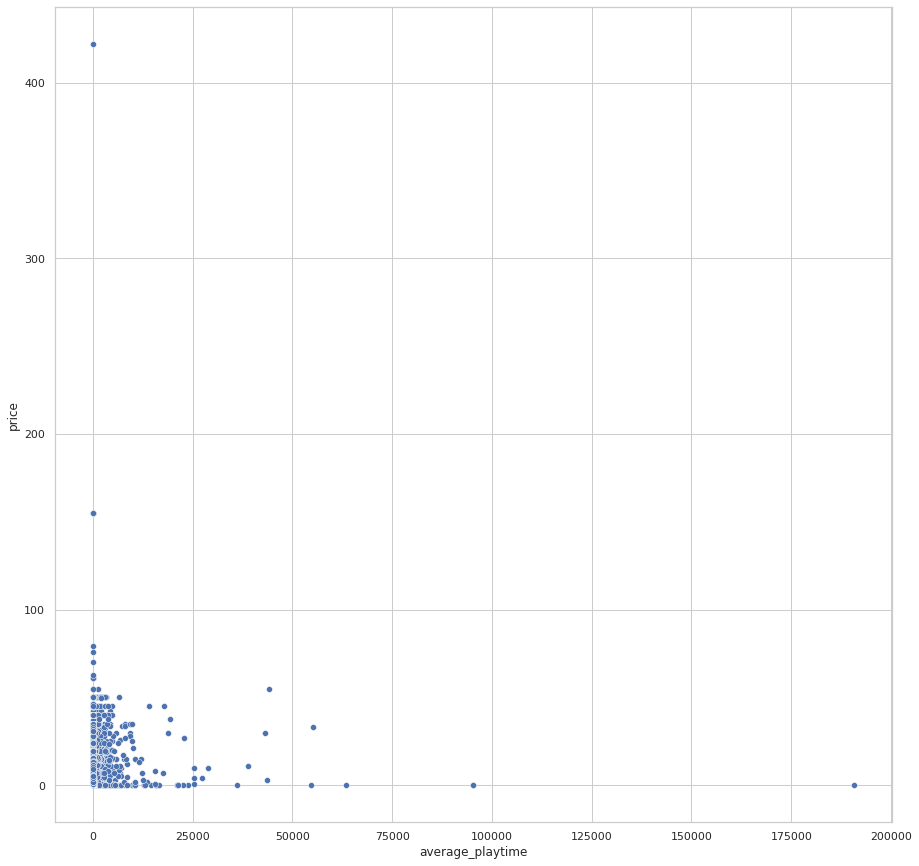

In [11]:
#@title Handling Outlier_1

# Preporcessing average_playtime & price
sns.set_style('whitegrid')
sns.scatterplot(x='average_playtime', y='price', data=df[['average_playtime', 'price']])
plt.show()

- Handling Outlier (2/2)

> `price`: IQR (weight: `1.5`)

> `average_playtime`: z-score (weight: `3`) 

---

> Distribution of `average_playtime` is not Normal Distribution. But `average_playtime`.quantile(0.75) == `average_playtime`.quantile(0.25) == 0. So inevitably use z-score.






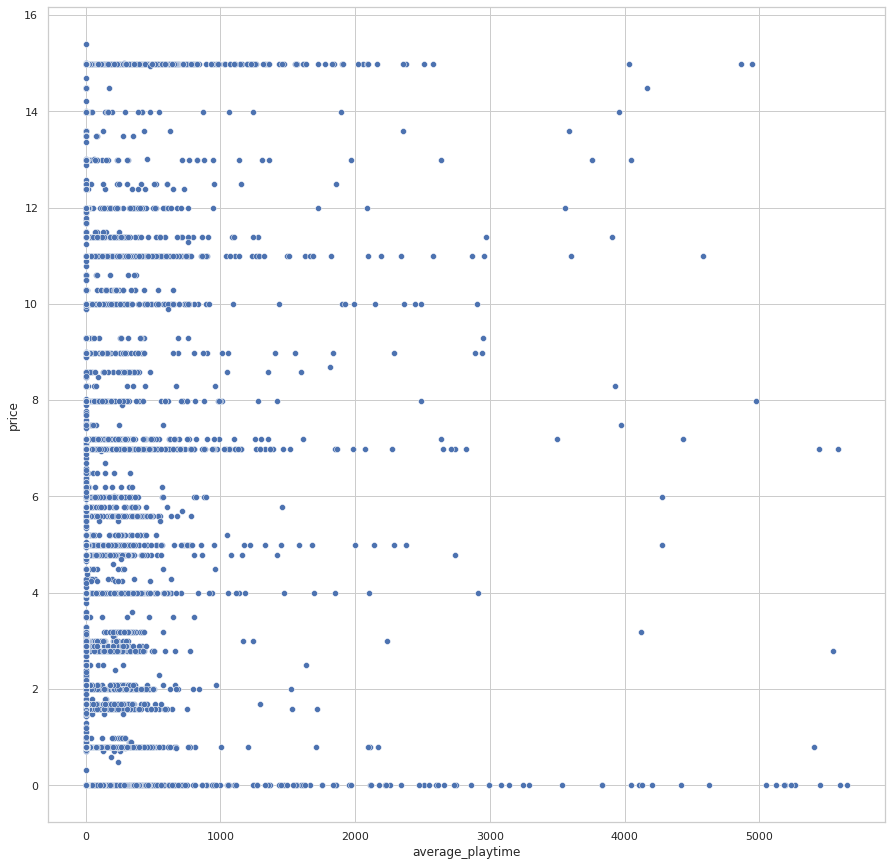

In [12]:
#@title Handling Outlier_2

# Handling Outlier
df_IQR = df[['average_playtime', 'price', 'owner_level']]

# Handling Outlier(IQR): price
price_IQR = df.price.quantile(0.75) - df.price.quantile(0.25)
average_playtime_IQR = df.average_playtime.quantile(0.75) - df.average_playtime.quantile(0.25)

# Handling Outlier(z-core): average_playtime (cause: IQR == 0.0)
idx_num2 = df[(df.price > df.price.quantile(0.75) + 1.5 * price_IQR) | 
              (df.price < df.price.quantile(0.25) - 1.5 * price_IQR) | 
              (df.average_playtime > df.average_playtime.mean() + 3 * df.average_playtime.std()) | 
              (df.average_playtime < df.average_playtime.mean() - 3 * df.average_playtime.std())].index
df_IQR = df_IQR.drop(idx_num2)

sns.set_style('whitegrid')
sns.scatterplot(x='average_playtime', y='price', data=df_IQR)

plt.show()

# **Clustering**: K-Means & Agglomerative Clustering

- Scaling

> Normalization: (data - data.MIN) / (data.MAX - data.MIN)

> Clustering use distance. So needs to scaling data to make equivalent weight. 

---

- WCSS (Inside-Cluster-Sum-of-Squares)

> $WCSS=\sum_{i=0}^n\sum_{j=0}^m distance(P_j, C_i)^2$ 

> ($n$: the number of cluster, $m$: the number of instance in cluster)

> There is a `Elbow` when $n = 4$

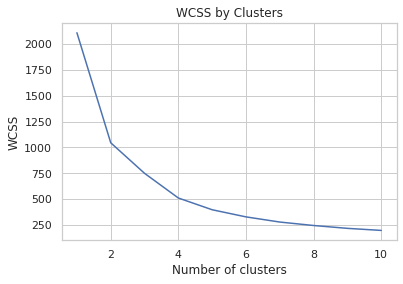

In [13]:
#@title Scaling(Normalization) & WCSS

from sklearn.cluster import KMeans
%matplotlib inline

# Scaling(Normalization)
X = df_IQR
for col in X:
 X[col] = (X[col] - X[col].min()) / (X[col].max() - X[col].min())

# WCSS values for 1 to 10 clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(X.values)
    wcss.append(kmeans.inertia_)
    
# Plot the WCSS values
plt.plot(range(1, 11), wcss)
plt.title('WCSS by Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

- K-Means Clustering

> Features: `average_playtime', 'price', 'owner_level`

> n_clusters: `4`

> random_state: `42`

In [14]:
#@title K-Means Clustering

from sklearn.cluster import KMeans

# k-Means: Create a model based on 4 clusters
model = KMeans(n_clusters=4,random_state=42)
km_clusters = model.fit_predict(X)

X_withCluster = X.copy()
X_withCluster['km_clusters'] = km_clusters

- Agglomerative Clustering

> Features: `average_playtime', 'price', 'owner_level`

> n_clusters: `4`

> llinkage: `average`

In [15]:
#@title Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering

# Agglomerative: Create a model based on 4 clusters
agg_model = AgglomerativeClustering(n_clusters=4, linkage='average')
agg_clusters = agg_model.fit_predict(X)

X_withCluster['agg_clusters'] = agg_clusters

- Silhouette Score

> $Sil_i = \frac{b_i - a_i}{max(a_i, b_i)}$

> ($a_i$: the average of intra cluster distance, $b_i$: the average of inter cluster distance)

> Generally, $Sil_i > 0.5$ means well-clustering.

In [16]:
#@title Silhouette score

from sklearn.metrics import silhouette_score

# Clustering Evaluation: Silhoutte
print('Silhouette of kMeans: %f'%silhouette_score(X,X_withCluster['km_clusters']))
print('Silhouette of Hierarchical Clustering: %f'%silhouette_score(X,X_withCluster['agg_clusters']))

Silhouette of kMeans: 0.513017
Silhouette of Hierarchical Clustering: 0.493770


- Distribution of Clusters


> K-Means Clustering

> * weight of `price` is too high. 
* `average_playtime`is biased to $0.0$ and `owner_level` is too categorical. 
* So they're hard to effect on centroid.

---

> Hierachical Clustering

> * Cluster 0: Free and Massive-Multiplayer Online Games like "DOTA"
* Cluster 1: Paid and Massive-Multiplayer Online Games like "PUBG: Battle Ground"
* Cluster 2: Well-made Singleplayer Games like "Assassin Creed"
* Cluster 3: Maniac and Indie Singleplayer Games like "ALTF4"

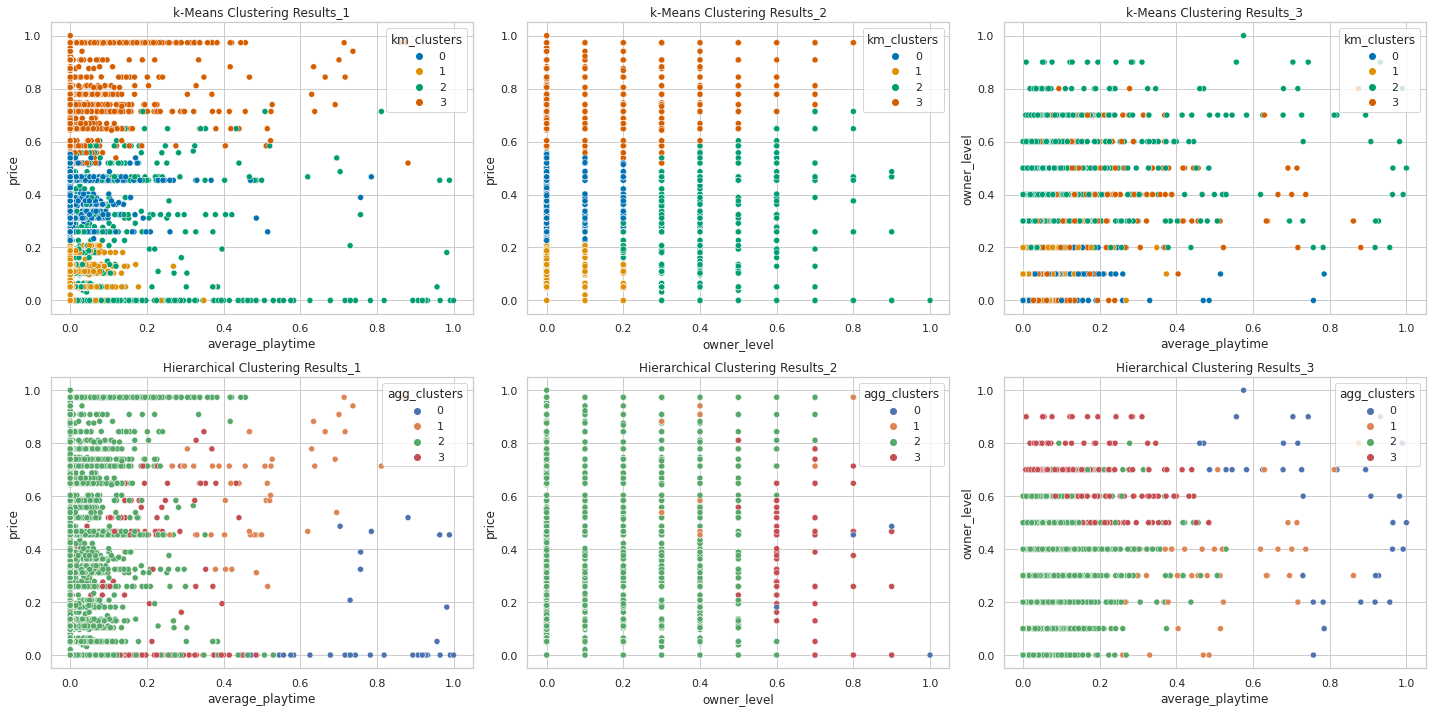

In [17]:
#@title Distribution of Clusters: scatterplot

# Scatterplot for Clustering and Features
fig, ax = plt.subplots(2, 3, figsize=(20,10))

sns.scatterplot(x='average_playtime', y='price', data=X_withCluster, hue='km_clusters',
           palette='colorblind', ax=ax[0, 0])
sns.scatterplot(x='average_playtime', y='price', data=X_withCluster, hue='agg_clusters',
           palette='deep', ax=ax[1, 0])
sns.scatterplot(x='owner_level', y='price', data=X_withCluster, hue='km_clusters',
           palette='colorblind', ax=ax[0, 1])
sns.scatterplot(x='owner_level', y='price', data=X_withCluster, hue='agg_clusters',
           palette='deep', ax=ax[1, 1])
sns.scatterplot(x='average_playtime', y='owner_level', data=X_withCluster, hue='km_clusters',
           palette='colorblind', ax=ax[0, 2])
sns.scatterplot(x='average_playtime', y='owner_level', data=X_withCluster, hue='agg_clusters',
           palette='deep', ax=ax[1, 2])

ax[0, 0].set(title='k-Means Clustering Results_1')
ax[1, 0].set(title='Hierarchical Clustering Results_1')
ax[0, 1].set(title='k-Means Clustering Results_2')
ax[1, 1].set(title='Hierarchical Clustering Results_2')
ax[0, 2].set(title='k-Means Clustering Results_3')
ax[1, 2].set(title='Hierarchical Clustering Results_3')

fig.tight_layout()

plt.show()

# **Multi-label Classification**: Classification without Balancing Data

- Add target on Data Set

> Hierachical Clustering Result(`agg_clusters`) is suitable to analysis purpose.

> Add attribution and drop outliers.

In [18]:
#@title Add attribute of cluster data

# Use agg_cluster for classification target
df = pd.concat([df,X_withCluster[['agg_clusters']]], axis=1)

# Drop NaN (Outliear)
df_noNA = df.dropna()
df_noNA.head()

,appid,release_date,publisher,required_age,genres,rating,total_ratings,average_playtime,median_playtime,owners,owner_level,price,Action,Adventure,Casual,Early Access,Free to Play,Gore,Indie,Massively Multiplayer,Nudity,RPG,Racing,Sexual Content,Simulation,Sports,Strategy,Violent,year,month,agg_clusters
1,20,1999-04-01,Valve,0,Action,0.839787,3951,277,62,7500000,8,3.99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1999,4,3.0
2,30,2003-05-01,Valve,0,Action,0.895648,3814,187,34,7500000,8,3.99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2003,5,3.0
3,40,2001-06-01,Valve,0,Action,0.826623,1540,258,184,7500000,8,3.99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2001,6,3.0
4,50,1999-11-01,Valve,0,Action,0.947996,5538,624,415,7500000,8,3.99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1999,11,3.0
5,60,2000-11-01,Valve,0,Action,0.801278,3442,175,10,7500000,8,3.99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000,11,3.0


- Choose features on Data Set

> Features which used in Hierachical Clustering should be excluded.

>  Non-numeric, non-related, and redundant attributes should be excluded. 

---

- Multi-label Classification without Balancing Data (1/4)

> Features: `Action`, `Adventure`, `Casual`, `Early Access`, `Free to Play`,
       `Gore`, `Indie`, `Massively Multiplayer`, `Nudity`, `RPG`,
       `Racing`, `Sexual Content`, `Simulation`, `Sports`, `Strategy`,
       `Violent`, `rating`, `required_age`, `total_ratings`, `year`

> Target: `agg_clusters`

> test_set: 20% (`0.2`)

> random_state: `0`


In [19]:
#@title Selcet features and split data

# Classification without Balancing Data
drop_attribute = ['appid', 'release_date', 'publisher', 'genres', 'average_playtime', 
                  'median_playtime', 'owners', 'owner_level', 'price', 'month', 'agg_clusters']
features = np.setdiff1d(df.columns, drop_attribute)

# Data Split: Classification(Features -> agg_clusters)
X1_train, X1_test, y1_train, y1_test = train_test_split(df_noNA[features], df_noNA['agg_clusters'], 
                                                    test_size=0.2, random_state=0)

- Multi-label Classification without Balancing Data (2/4)

> * Logistic Regression: max_iter=`5000`
*   kNN: n_neighbor=`5`
*   Naive Bayes: GausianNB
*   Decision Tree: Feature Importance include
*   Random Forest: Feature Importance include
*   Support Vector Machine(SVM): gamma=`'auto'`

In [20]:
#@title Learn classification model without balancing data

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

models1 = []

# Logistic Regression
log_reg1 = LogisticRegression(max_iter=5000)
log_reg1.fit(X1_train, y1_train)
models1.append((0, 'Logistic Regression', log_reg1))

# K-Nearest Neighbor Classification
kNN1 = KNeighborsClassifier(n_neighbors=5)
kNN1.fit(X1_train, y1_train)
models1.append((1, '        kNN        ', kNN1))

# Gaussian Naive Bayes
GNB1 = GaussianNB()
GNB1.fit(X1_train, y1_train)
models1.append((2, '    Naive Bayes    ', GNB1))

# Decision Tree Classification
DTC1 = DecisionTreeClassifier()
DTC1 = DTC1.fit(X1_train, y1_train)
models1.append((3, '   Decision Tree   ', DTC1))

# Random Forest Classification
RFC1 = RandomForestClassifier()
RFC1 = RFC1.fit(X1_train, y1_train)
models1.append((4, '   Random Forest   ', RFC1))

# Support Vector Machine
svm1 = SVC(gamma='auto')
svm1.fit(X1_train, y1_train)
models1.append((5, '        SVM        ', svm1))

- Multi-label Classification without Balancing Data (3/4)

> Evaluation: 
> * Accuray: (TP + TN) / (TP + TN + FP + FN)
*   Precision: TP / (TP + FP)
*   Recall: TP / (TP + FN)
*   F1-Score: harmonic mean of Precision and Recall
*   Classification Report: Score of each cluster
*   Confusion Matrix: Rate or the number of instance between prediction and actual value

---

> * Representative values of Precision, Recall, F1-Score are calculated by "average=`'micro'`"

> * micro: Calculate with sum of TP, FP, FN in each cluster
*   macro: arithmetic mean of each cluster
*   weighted: weighted mean of each cluster

---

> * Accuracy, Precision, Recall, and F1_Score are not bad. But Confusion Matrix shows models didn't classified instances well. Imbalance of the number of instance in each clusters makes model performance low. 


/* =============== Logistic Regression ================ */

Accuracy: 0.9901428284047475
Precision(micro): 0.9901428284047475
Recall(micro): 0.9901428284047475
F1-Score(micro): 0.9901428284047475 

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         2.0       0.99      1.00      1.00      4915
         3.0       0.62      0.33      0.43        46

   micro avg       0.99      0.99      0.99      4965
   macro avg       0.54      0.44      0.47      4965
weighted avg       0.99      0.99      0.99      4965


/* ===============         kNN         ================ */

Accuracy: 0.9895393281029974
Precision(micro): 0.9895393281029974
Recall(micro): 0.9895393281029974
F1-Score(micro): 0.9895393281029974 

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         2.0       0.99      1.00      1.00      4915
         3.0       0.54      0.41      0.47        46

   

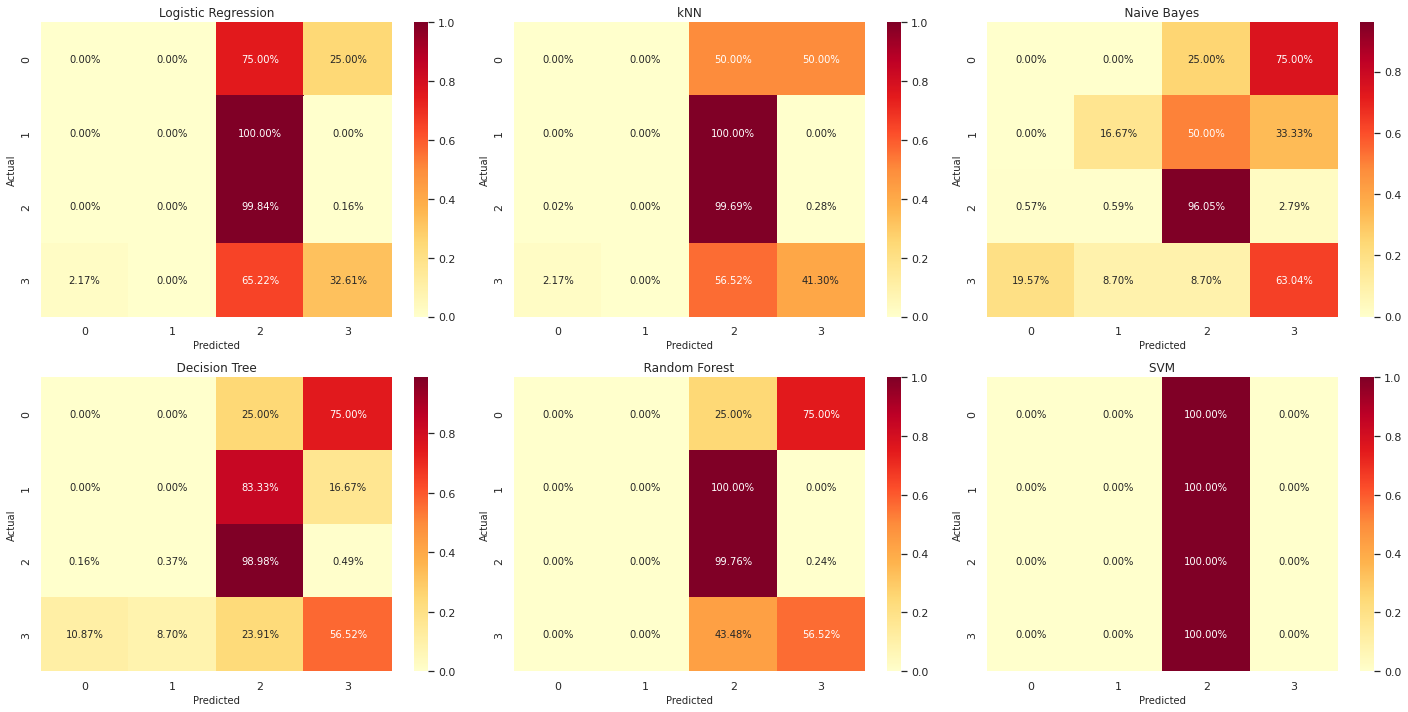

In [21]:
#@title Evaluate classification model with out balancing data

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# Evaluation
fig, ax = plt.subplots(2, 3, figsize=(20,10))

for i, name, model in models1:
  predictions = model.predict(X1_test)
  cm = confusion_matrix(y1_test, predictions)
  print('\n/* =============== {} ================ */'.format(name))
  print("\nAccuracy:", accuracy_score(y1_test, predictions))
  print("Precision(micro):", precision_score(y1_test, predictions, average='micro'))
  print("Recall(micro):", recall_score(y1_test, predictions, average='micro'))
  print("F1-Score(micro):", f1_score(y1_test, predictions, average='micro'),"\n")
  print(classification_report(y1_test, predictions, labels=np.unique(predictions)))

# Confusion Matrix
  _cm = [[],[],[],[]]
  for m in np.arange(len(cm)):
    tmp = np.sum(cm[m])
    for n in np.arange(len(cm)):
      _cm[m].append(float(cm[m, n]  * 1.0 / tmp))
  
  sns.heatmap(_cm, annot=True, fmt='.2%', cmap='YlOrRd', ax=ax[int(i / 3), int(i % 3)])
  ax[int(i / 3), int(i % 3)].set(title=name)
  ax[int(i / 3), int(i % 3)].set(xlabel='Predicted')
  ax[int(i / 3), int(i % 3)].set(ylabel='Actual')
  ax[int(i / 3), int(i % 3)].xaxis.label.set_size(10)
  ax[int(i / 3), int(i % 3)].yaxis.label.set_size(10)

fig.tight_layout()

plt.show()

- Multi-label Classification without Balancing Data (4/4)

> Calcualte feature_importances of Decision Tree and Random Forest Classification. It sort in ascending=`'False'`

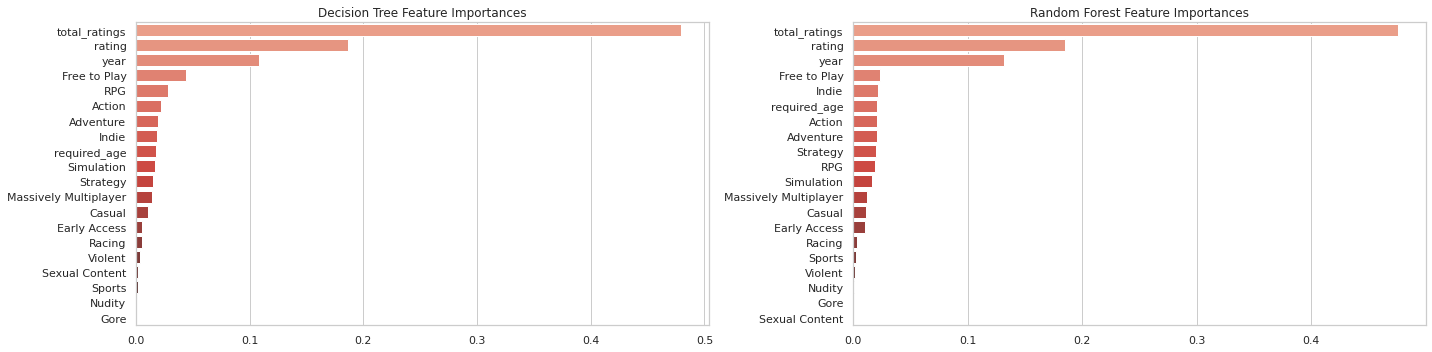

In [22]:
#@title Feature importances of Decision Tree and Random Forest

# feature_importance of DTC1 & RFC1
f_importances_DTC1 = pd.Series(DTC1.feature_importances_, index=X1_train.columns)
f_importances_DTC1 = f_importances_DTC1.sort_values(ascending=False)
f_importances_RFC1 = pd.Series(RFC1.feature_importances_, index=X1_train.columns)
f_importances_RFC1 = f_importances_RFC1.sort_values(ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(20,5))

sns.barplot(x=f_importances_DTC1, y=f_importances_DTC1.index, palette="Reds_d", ax=ax[0])
ax[0].set(title='Decision Tree Feature Importances')
sns.barplot(x=f_importances_RFC1, y=f_importances_RFC1.index, palette="Reds_d", ax=ax[1])
ax[1].set(title='Random Forest Feature Importances')

fig.tight_layout()

plt.show()

# **Multi-label Classification**: Classification with Over-sampling Data

- Over-sampling

> Difference between the number of instances in each cluster are too big. Models couln't learn about minor cluster. So make 
plausible instances for minor cluster with SMOTE over-sampling

---

- Multi-label Classification with Over-sampling Data (1/4)

> Features: `Action`, `Adventure`, `Casual`, `Early Access`, `Free to Play`,
       `Gore`, `Indie`, `Massively Multiplayer`, `Nudity`, `RPG`,
       `Racing`, `Sexual Content`, `Simulation`, `Sports`, `Strategy`,
       `Violent`, `rating`, `required_age`, `total_ratings`, `year`

> Target: `agg_clusters`

> test_set: 20% (`0.2`)

> random_state: `0`

In [23]:
#@title Over-sampling and split data

from imblearn.over_sampling import SMOTE

# Classification with Balancing Data
smote = SMOTE(random_state=0)
X_sm, y_sm = smote.fit_resample(df_noNA[features], df_noNA['agg_clusters'])

# Data Split: Classification(Features -> agg_clusters)
X2_train, X2_test, y2_train, y2_test = train_test_split(X_sm, y_sm, 
                                                        test_size=0.2, random_state=0)

- Multi-label Classification with Over-sampling Data (2/4)

> * Logistic Regression: max_iter=`5000`
*   kNN: n_neighbor=`5`
*   Naive Bayes: GausianNB
*   Decision Tree: Feature Importance include
*   Random Forest: Feature Importance include
*   Support Vector Machine(SVM): gamma=`'auto'`

In [24]:
#@title Learn classification model with over-sampling data

models2 = []

# Logistic Regression
log_reg2 = LogisticRegression(max_iter=5000)
log_reg2.fit(X2_train, y2_train)
models2.append((0, 'Logistic Regression', log_reg2))

# K-Nearest Neighbor Classification
kNN2 = KNeighborsClassifier(n_neighbors=5)
kNN2.fit(X2_train, y2_train)
models2.append((1, '        kNN        ', kNN2))

# Gaussian Naive Bayes
GNB2 = GaussianNB()
GNB2.fit(X2_train, y2_train)
models2.append((2, '    Naive Bayes    ', GNB2))

# Decision Tree Classification
DTC2 = DecisionTreeClassifier()
DTC2 = DTC2.fit(X2_train, y2_train)
models2.append((3, '   Decision Tree   ', DTC2))

# Random Forest Classification
RFC2 = RandomForestClassifier()
RFC2 = RFC2.fit(X2_train, y2_train)
models2.append((4, '   Random Forest   ', RFC2))

# Support Vector Machine
svm2 = SVC(gamma='auto')
svm2.fit(X2_train, y2_train)
models2.append((5, '        SVM        ', svm2))

- Multi-label Classification with Over-sampling Data (3/4)

> Evaluation: 
> * Accuray: (TP + TN) / (TP + TN + FP + FN)
*   Precision: TP / (TP + FP)
*   Recall: TP / (TP + FN)
*   F1-Score: harmonic mean of Precision and Recall
*   Classification Report: Score of each cluster
*   Confusion Matrix: Rate or the number of instance between prediction and actual value

---

> * Representative values of Precision, Recall, F1-Score are calculated by "average=`'micro'`"

> * micro: Calculate with sum of TP, FP, FN in each cluster
*   macro: arithmetic mean of each cluster
*   weighted: weighted mean of each cluster

---

> * Accuracy, Precision, Recall, and F1_Score are decrease than model without balabcing data. But Confusion Matrix shows models have better performance than model without balancing data. Equivalent number of instance in each clusters makes model performance better. 


/* =============== Logistic Regression ================ */

Accuracy: 0.6931354549163606
Precision(micro): 0.6931354549163606
Recall(micro): 0.6931354549163606
F1-Score(micro): 0.6931354549163606 

              precision    recall  f1-score   support

         0.0       0.73      0.69      0.71      4899
         1.0       0.69      0.61      0.65      4975
         2.0       0.68      0.87      0.76      4899
         3.0       0.68      0.60      0.64      4835

    accuracy                           0.69     19608
   macro avg       0.69      0.69      0.69     19608
weighted avg       0.69      0.69      0.69     19608


/* ===============         kNN         ================ */

Accuracy: 0.8227254181966545
Precision(micro): 0.8227254181966545
Recall(micro): 0.8227254181966545
F1-Score(micro): 0.8227254181966545 

              precision    recall  f1-score   support

         0.0       0.73      0.82      0.77      4899
         1.0       0.80      0.83      0.82      4975
    

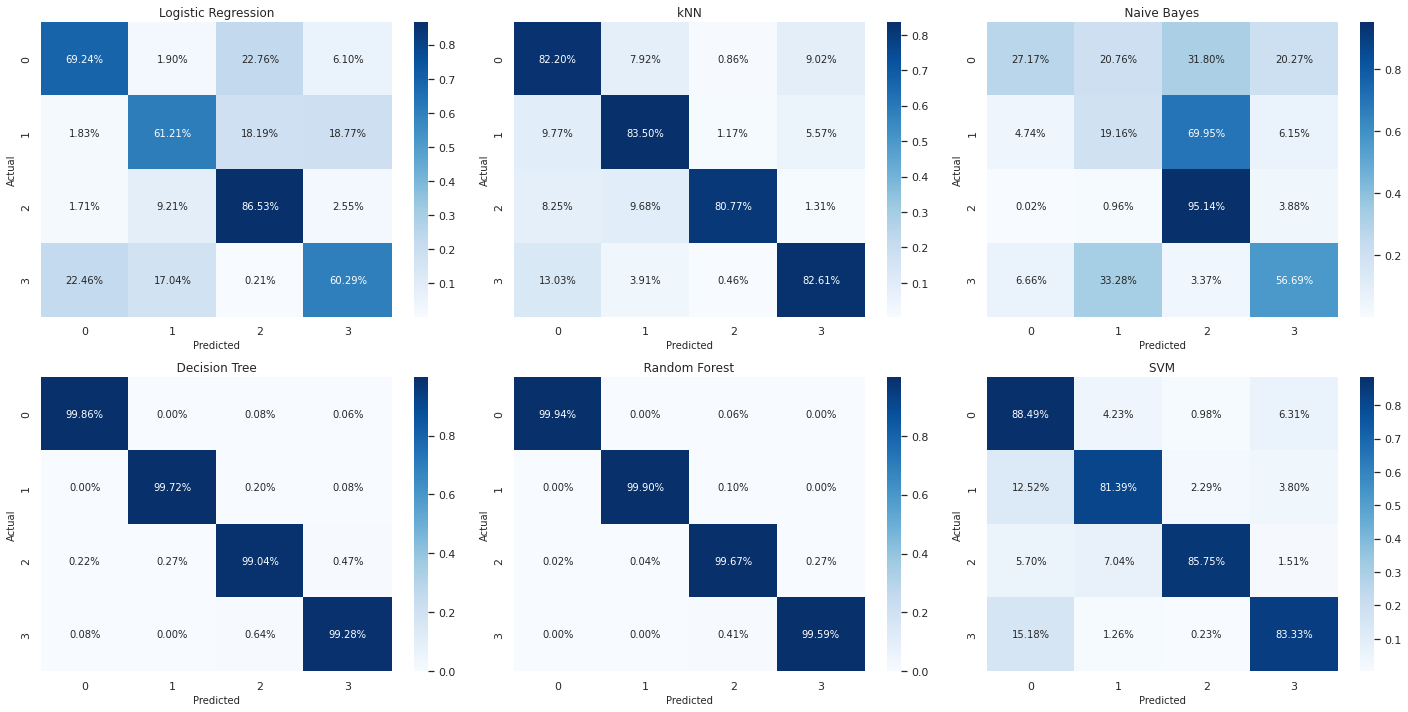

In [25]:
#@title Evaluate classification model with over-sampling data

# Evaluation
fig, ax = plt.subplots(2, 3, figsize=(20,10))

for i, name, model in models2:
  predictions = model.predict(X2_test)
  cm = confusion_matrix(y2_test, predictions)
  print('\n/* =============== {} ================ */'.format(name))
  print("\nAccuracy:", accuracy_score(y2_test, predictions))
  print("Precision(micro):", precision_score(y2_test, predictions, average='micro'))
  print("Recall(micro):", recall_score(y2_test, predictions, average='micro'))
  print("F1-Score(micro):", f1_score(y2_test, predictions, average='micro'),"\n")
  print(classification_report(y2_test, predictions, labels=np.unique(predictions)))

# Confusion Matrix
  _cm = [[],[],[],[]]
  for m in np.arange(len(cm)):
    tmp = np.sum(cm[m])
    for n in np.arange(len(cm)):
      _cm[m].append(float(cm[m, n]  * 1.0 / tmp))
  
  sns.heatmap(_cm, annot=True, fmt='.2%', cmap='Blues', ax=ax[int(i / 3), int(i % 3)])
  ax[int(i / 3), int(i % 3)].set(title=name)
  ax[int(i / 3), int(i % 3)].set(xlabel='Predicted')
  ax[int(i / 3), int(i % 3)].set(ylabel='Actual')
  ax[int(i / 3), int(i % 3)].xaxis.label.set_size(10)
  ax[int(i / 3), int(i % 3)].yaxis.label.set_size(10)

fig.tight_layout()

plt.show()

- Multi-label Classification with Over-sampling Data (4/4)

> Calcualte feature_importances of Decision Tree and Random Forest Classification. It sort in ascending=`'False'`

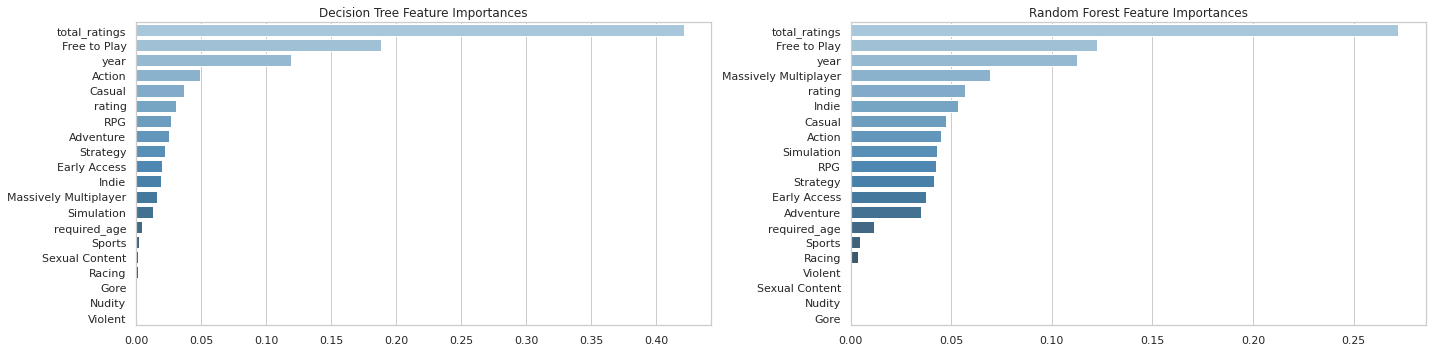

In [26]:
#@title Feature importances of Decision Tree and Random Forest

# feature_importance for DTC2 & RFC2
f_importances_DTC2 = pd.Series(DTC2.feature_importances_, index=X2_train.columns)
f_importances_DTC2 = f_importances_DTC2.sort_values(ascending=False)
f_importances_RFC2 = pd.Series(RFC2.feature_importances_, index=X2_train.columns)
f_importances_RFC2 = f_importances_RFC2.sort_values(ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(20,5))

sns.barplot(x=f_importances_DTC2, y=f_importances_DTC2.index, palette="Blues_d", ax=ax[0])
ax[0].set(title='Decision Tree Feature Importances')
sns.barplot(x=f_importances_RFC2, y=f_importances_RFC2.index, palette="Blues_d", ax=ax[1])
ax[1].set(title='Random Forest Feature Importances')

fig.tight_layout()

plt.show()